# Conditional DDPM on MNIST with Class Labels

### Import Libraries and Set Device

Import all necessary libraries for building and training a class-conditioned diffusion model on MNIST, and set the device (GPU or CPU) for computation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


### Prepare MNIST Dataset with Class Labels

Defines a custom dataset that loads MNIST images and their corresponding digit class labels. Also visualizes a few random samples from the training set to confirm correct data loading.

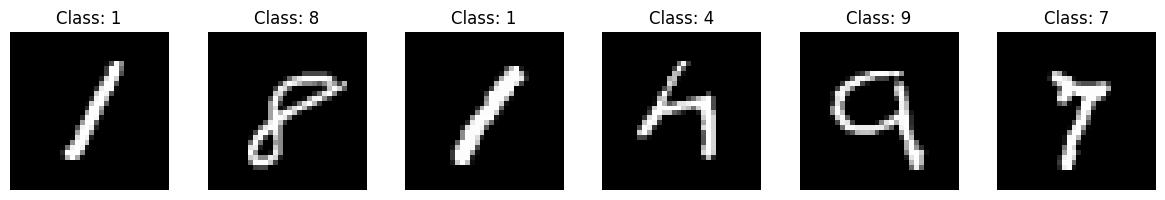

In [ ]:
class MNISTWithClass(Dataset):
    def __init__(self, train=True):
        self.data = datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transforms.Compose([
                transforms.Pad(2),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x * 2. - 1.)
            ])
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

train_dataset = MNISTWithClass(train=True)
test_dataset = MNISTWithClass(train=False)

# visualize some samples from the training set
n_samples = 6
indices = np.random.choice(len(train_dataset), n_samples, replace=False)
plt.figure(figsize=(12, 2))
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    plt.subplot(1, n_samples, i+1)
    plt.imshow((img[0].numpy() + 1) / 2, cmap='gray')
    plt.title(f"Class: {label}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Class Embedding Layer

Defines a learnable embedding layer that maps each digit class (0–9) to a vector representation. An extra embedding is included for the "null" class (used for unconditional generation). The helper function ensures class labels are properly converted to embeddings on the correct device.

In [ ]:
class ClassEmbedding(nn.Module):
    def __init__(self, num_classes=10, embedding_dim=128):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_classes + 1, embedding_dim)

    def forward(self, class_labels):
        labels = class_labels.clone()
        labels[labels == -1] = self.num_classes  # Map -1 to num_classes
        return self.embedding(labels)

class_embedding = ClassEmbedding(num_classes=10, embedding_dim=128).to(device)

def get_class_embedding(class_labels, device):
    if isinstance(class_labels, list):
        class_labels = torch.tensor(class_labels, device=device)
    return class_embedding(class_labels)

### Sinusoidal Time Embedding Function

Defines a function to create sinusoidal timestep embeddings, allowing the model to recognize the current step in the diffusion process.

In [ ]:
def get_timestep_embedding(timesteps, embedding_dim):
    half_dim = embedding_dim // 2
    exponent = torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) / half_dim
    exponent = 10000 ** (-exponent)
    emb = timesteps[:, None].float() * exponent[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    if embedding_dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

### Self-Attention and Cross-Attention Modules

Defines modules for self-attention (to capture global dependencies within the image) and cross-attention (to integrate class or context information with image features).

In [ ]:
class SelfAttention2d(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        k = self.k(x_norm).reshape(B, C, H*W)  # (B, C, HW)
        v = self.v(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        attn = torch.bmm(q, k) / (C ** 0.5)  # (B, HW, HW)
        attn = torch.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        out = self.proj(out)
        return x + out

class CrossAttention(nn.Module):
    def __init__(self, channels, context_dim):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Linear(context_dim, channels)
        self.v = nn.Linear(context_dim, channels)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x, context):
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        k = self.k(context).unsqueeze(1)  # (B, 1, C)
        v = self.v(context).unsqueeze(1)  # (B, 1, C)
        attn = torch.bmm(q, k.transpose(1, 2)) / (C ** 0.5)  # (B, HW, 1)
        attn = torch.softmax(attn, dim=1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        out = self.proj(out)
        return x + out

### U-Net Architecture with Skip Connections and Conditioning

Defines the U-Net model for denoising, using downsampling and upsampling blocks with skip connections. Each block can incorporate self- and cross-attention, and both time and class conditioning are injected to guide the denoising process.

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, context_dim, use_attn=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.use_attn = use_attn
        if use_attn:
            self.attn = SelfAttention2d(out_ch)
            self.cross_attn = CrossAttention(out_ch, context_dim)
        self.down = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, t_emb, context):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h + self.emb_proj(t_emb)[:, :, None, None])
        h = self.conv2(h)
        h = self.norm2(h)
        if self.use_attn:
            h = self.attn(h)
            h = self.cross_attn(h, context)
        h_down = self.down(h)
        return h_down, h

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, context_dim, use_attn=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.use_attn = use_attn
        if use_attn:
            self.attn = SelfAttention2d(out_ch)
            self.cross_attn = CrossAttention(out_ch, context_dim)
        self.up = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, skip, t_emb, context):
        # Center-crop skip to match x's spatial size
        def center_crop(tensor, target_height, target_width):
            _, _, h, w = tensor.shape
            start_h = (h - target_height) // 2
            start_w = (w - target_width) // 2
            return tensor[:, :, start_h:start_h+target_height, start_w:start_w+target_width]

        if x.shape[2:] != skip.shape[2:]:
            skip = center_crop(skip, x.shape[2], x.shape[3])
        h = torch.cat([x, skip], dim=1)
        h = self.conv1(h)
        h = self.norm1(h)
        h = F.silu(h + self.emb_proj(t_emb)[:, :, None, None])
        h = self.conv2(h)
        h = self.norm2(h)
        if self.use_attn:
            h = self.attn(h)
            h = self.cross_attn(h, context)
        h_up = self.up(h)
        return h_up

class UNet(nn.Module):
    def __init__(self, img_ch=1, base_ch=64, emb_dim=128, context_dim=128):
        super().__init__()
        self.init_conv = nn.Conv2d(img_ch, base_ch, 3, padding=1)
        self.down1 = DownBlock(base_ch, base_ch*2, emb_dim, context_dim, use_attn=False)
        self.down2 = DownBlock(base_ch*2, base_ch*4, emb_dim, context_dim, use_attn=True)
        self.down3 = DownBlock(base_ch*4, base_ch*8, emb_dim, context_dim, use_attn=True)
        self.bot1 = nn.Conv2d(base_ch*8, base_ch*8, 3, padding=1)
        self.bot2 = nn.Conv2d(base_ch*8, base_ch*8, 3, padding=1)
        self.up3 = UpBlock(base_ch*8+base_ch*8, base_ch*4, emb_dim, context_dim, use_attn=True)
        self.up2 = UpBlock(base_ch*4+base_ch*4, base_ch*2, emb_dim, context_dim, use_attn=True)
        self.up1 = UpBlock(base_ch*2+base_ch*2, base_ch, emb_dim, context_dim, use_attn=False)
        self.final_conv = nn.Conv2d(base_ch, img_ch, 1)

    def forward(self, x, t_emb, context):
        h0 = self.init_conv(x)
        h1_down, h1 = self.down1(h0, t_emb, context)
        h2_down, h2 = self.down2(h1_down, t_emb, context)
        h3_down, h3 = self.down3(h2_down, t_emb, context)
        h_bot = F.silu(self.bot1(h3_down))
        h_bot = F.silu(self.bot2(h_bot))
        h_up3 = self.up3(h_bot, h3, t_emb, context)
        h_up2 = self.up2(h_up3, h2, t_emb, context)
        h_up1 = self.up1(h_up2, h1, t_emb, context)
        out = self.final_conv(h_up1)
        return out

### Define Cosine Beta Scheduler for Diffusion

Implements a cosine schedule for the noise variance (beta) used in the diffusion process. This schedule often leads to better sample quality compared to a linear schedule, especially for image generation tasks.

In [ ]:
def make_cosine_beta_schedule(n_steps, s=0.008):
    steps = np.arange(n_steps + 1, dtype=np.float64)
    alphas_cumprod = np.cos(((steps / n_steps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.from_numpy(np.clip(betas, 0, 0.999)).float()

T = 1000  # Number of diffusion steps
betas = make_cosine_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

### Classifier-Free Guidance Function

Defines a function to combine conditional and unconditional model outputs during sampling.

In [ ]:
def classifier_free_guidance(model, x, t, context, null_context, guidance_scale):
    eps_cond = model(x, t, context)
    eps_uncond = model(x, t, null_context)
    return eps_uncond + guidance_scale * (eps_cond - eps_uncond)

### Training Loop for Class-Conditioned DDPM

Trains the U-Net model to predict the noise added to images at each diffusion step, conditioned on class labels.

In [ ]:
batch_size = 64
n_epochs = 30

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

context_dim = 128
emb_dim = 128
model = UNet(img_ch=1, base_ch=64, emb_dim=emb_dim, context_dim=context_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# Prepare null context for classifier-free guidance (use class 10 for null)
null_context = get_class_embedding([10] * batch_size, device)

# Lists to track losses
epoch_losses = []
step_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    num_steps = 0

    for imgs, labels in tqdm(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        t = torch.randint(0, T, (imgs.size(0),), device=device)
        noise = torch.randn_like(imgs)
        alpha_cumprod_t = alphas_cumprod.to(device)[t].reshape(-1, 1, 1, 1)
        noisy_imgs = torch.sqrt(alpha_cumprod_t) * imgs + torch.sqrt(1 - alpha_cumprod_t) * noise

        # 10% of the time, use null context (unconditional)
        if random.random() < 0.1:
            context = get_class_embedding([10] * imgs.size(0), device)
        else:
            context = get_class_embedding(labels, device)

        t_emb = get_timestep_embedding(t, emb_dim)
        t_emb = t_emb.to(device)

        pred_noise = model(noisy_imgs, t_emb, context)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track losses
        step_losses.append(loss.item())
        epoch_loss += loss.item()
        num_steps += 1

    avg_epoch_loss = epoch_loss / num_steps
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} done. Average Loss: {avg_epoch_loss:.4f}")

100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 1 done. Average Loss: 0.7641


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 2 done. Average Loss: 0.4181


100%|██████████| 938/938 [02:16<00:00,  6.87it/s]


Epoch 3 done. Average Loss: 0.2813


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 4 done. Average Loss: 0.2310


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 5 done. Average Loss: 0.2110


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 6 done. Average Loss: 0.1978


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 7 done. Average Loss: 0.1866


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 8 done. Average Loss: 0.1764


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 9 done. Average Loss: 0.1663


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 10 done. Average Loss: 0.1580


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 11 done. Average Loss: 0.1510


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 12 done. Average Loss: 0.1447


100%|██████████| 938/938 [02:15<00:00,  6.90it/s]


Epoch 13 done. Average Loss: 0.1362


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 14 done. Average Loss: 0.1293


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 15 done. Average Loss: 0.1233


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 16 done. Average Loss: 0.1176


100%|██████████| 938/938 [02:15<00:00,  6.90it/s]


Epoch 17 done. Average Loss: 0.1118


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 18 done. Average Loss: 0.1071


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 19 done. Average Loss: 0.1032


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 20 done. Average Loss: 0.0966


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 21 done. Average Loss: 0.0901


100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


Epoch 22 done. Average Loss: 0.0853


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 23 done. Average Loss: 0.0821


100%|██████████| 938/938 [02:15<00:00,  6.90it/s]


Epoch 24 done. Average Loss: 0.0804


100%|██████████| 938/938 [02:15<00:00,  6.91it/s]


Epoch 25 done. Average Loss: 0.0788


100%|██████████| 938/938 [02:15<00:00,  6.90it/s]


Epoch 26 done. Average Loss: 0.0757


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 27 done. Average Loss: 0.0736


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 28 done. Average Loss: 0.0708


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Epoch 29 done. Average Loss: 0.0675


100%|██████████| 938/938 [02:16<00:00,  6.89it/s]

Epoch 30 done. Average Loss: 0.0632


### Plot Training Loss

Visualizes the training loss over epochs and steps to monitor model convergence and training stability. The final and best average losses are also displayed for reference.

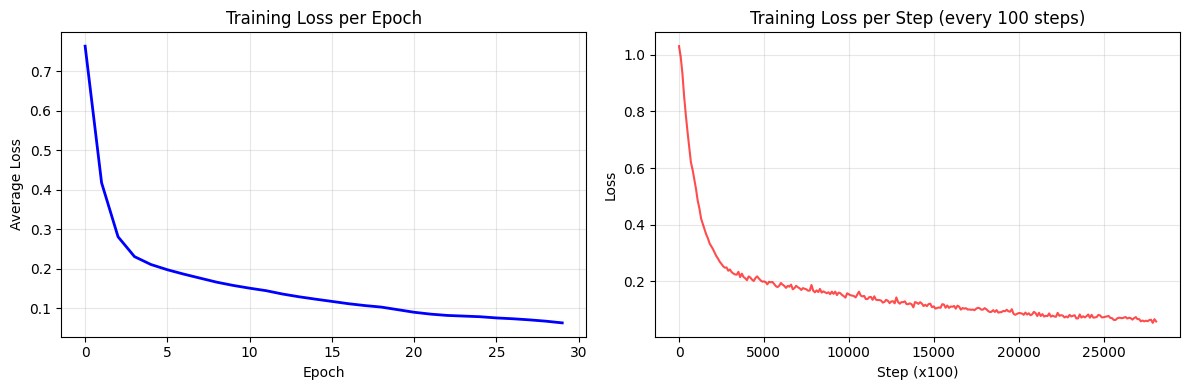

Final average loss: 0.0632
Best loss: 0.0632


In [ ]:
# Plot the training loss
plt.figure(figsize=(12, 4))

# Plot epoch losses
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, 'b-', linewidth=2)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)

# Plot step losses (every 100 steps for clarity)
plt.subplot(1, 2, 2)
step_indices = range(0, len(step_losses), 100)
plt.plot(step_indices, [step_losses[i] for i in step_indices], 'r-', alpha=0.7)
plt.title('Training Loss per Step (every 100 steps)')
plt.xlabel('Step (x100)')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final average loss: {epoch_losses[-1]:.4f}")
print(f"Best loss: {min(epoch_losses):.4f}")

### Visualize Denoising Process for Class Labels

Generates and displays a grid of images showing the denoising trajectory for different digit classes.

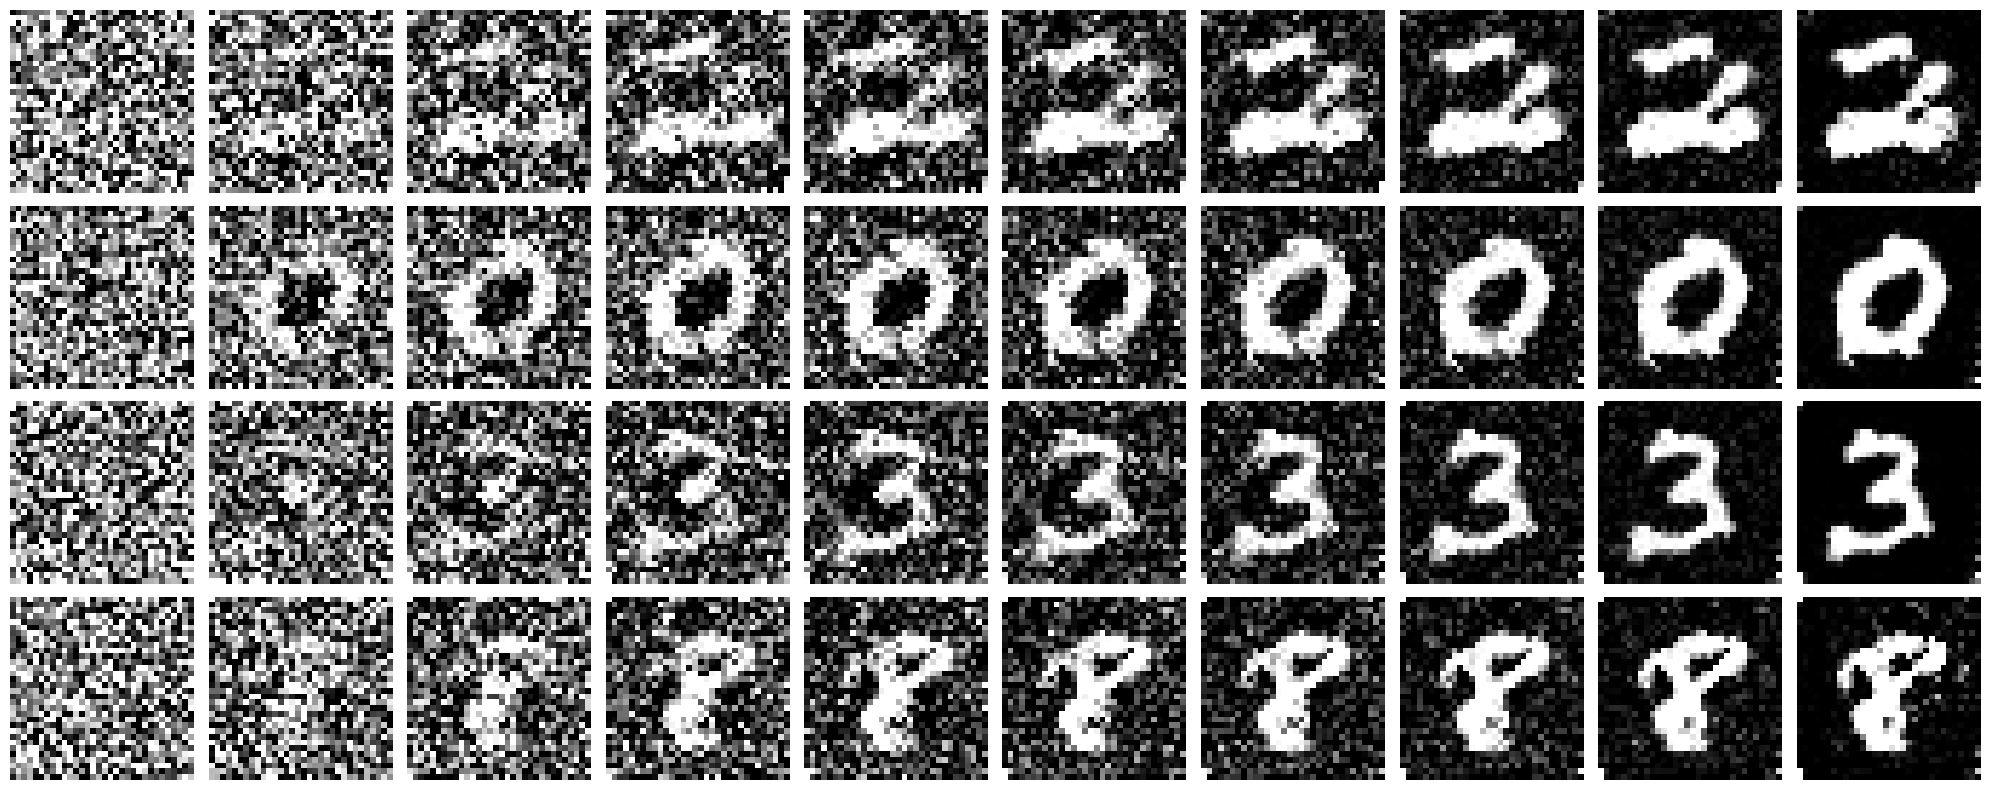

In [ ]:
def sample_ddpm_grid(model, class_labels, steps=1000, n_cols=10, guidance_scale=5.0):
    model.eval()
    n_rows = len(class_labels)
    step_indices = np.linspace(steps-1, 0, n_cols, dtype=int)

    all_imgs = []
    with torch.no_grad():
        for class_label in class_labels:
            context = get_class_embedding([class_label], device)
            null_context = get_class_embedding([10], device)  # Use 10 for null class
            x = torch.randn(1, 1, 32, 32).to(device)
            imgs = []
            for t_ in reversed(range(steps)):
                t = torch.full((1,), t_, device=device, dtype=torch.long)
                t_emb = get_timestep_embedding(t, emb_dim).to(device)
                eps = classifier_free_guidance(model, x, t_emb, context, null_context, guidance_scale)
                beta = betas[t_].to(device)
                alpha = alphas[t_].to(device)
                alpha_cumprod_t = alphas_cumprod[t_].to(device)
                if t_ > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod_t)) * eps) + torch.sqrt(beta) * noise
                if t_ in step_indices:
                    imgs.append((x[0, 0].cpu().numpy() + 1) / 2)
            all_imgs.append(imgs)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    for i in range(n_rows):
        for j in range(n_cols):
            if j < len(all_imgs[i]):
                axes[i, j].imshow(all_imgs[i][j], cmap='gray', vmin=0, vmax=1)
            else:
                axes[i, j].imshow(np.zeros((32, 32)), cmap='gray', vmin=0, vmax=1)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

class_labels = [2, 0, 3, 8]
sample_ddpm_grid(model, class_labels, steps=800, n_cols=10, guidance_scale=9)